In [11]:
import pandas as pd
df = pd.read_csv('tennis_final.csv')
df = df.drop(columns='Winner')
df1 = df.rename(columns={'Player A': 'Player_A', 'Player B':'Player_B', 'Player A bpFaced': 'Player_A_bpFaced',
                         'Player B bpFaced': 'Player_B_bpFaced', 'Player A bpSaved':'Player_A_bpSaved', 
                        'Player B bpSaved':'Player_B_bpSaved', 'Winner2': 'Winner'})
pd.set_option('display.max_columns', 500)

In [12]:
print(df1.shape)
df1.head()

(168302, 55)


,Unnamed: 0,Unnamed: 0.1,Player_A,Player A 1stIn,Player A 1stWon,Player A 2ndwon,Player A Entry,Player A Hand,Player A Height,Player A ID,Player A Name,Player A SvGms,Player A ace,Player_A_bpFaced,Player_A_bpSaved,Player A df,Player A ioc,Player A points,Player A rank,Player A seed,Player A svpt,Player_B,Player B 1stIn,Player B 1stWon,Player B 2ndwon,Player B Entry,Player B Hand,Player B Height,Player B ID,Player B Name,Player B SvGms,Player B ace,Player_B_bpFaced,Player_B_bpSaved,Player B df,Player B ioc,Player B points,Player B rank,Player B seed,Player B svpt,best_of,draw_size,match_num,minutes,players,round,score,surface,tourney_date,tourney_id,tourney_level,tourney_name,winner_name,year,Winner
0,64970,915,Sebastien Grosjean,48.0,32.0,25.0,NaN,R,175.0,103206,27.81,16.0,6.0,18.0,11.0,2.0,FRA,1450.0,20.0,19.0,106.0,David Ferrer,80.0,50.0,16.0,NaN,R,175.0,103970,23.96,16.0,1.0,11.0,5.0,5.0,ESP,1700.0,11.0,11.0,116.0,3,NaN,71,168.0,Player 2,R32,4-6 7-5 6-4,Hard,20060320,2006-403,M,Miami Masters,David Ferrer,2006,Player B
1,89521,1453,Jaime Fillol,NaN,NaN,NaN,NaN,R,180.0,100115,26.95,NaN,NaN,NaN,NaN,NaN,CHI,NaN,NaN,NaN,NaN,Robert Lutz,NaN,NaN,NaN,NaN,R,180.0,100144,25.71,NaN,NaN,NaN,NaN,NaN,USA,NaN,NaN,14.0,NaN,3,NaN,15,NaN,Player 1,R32,7-6 4-6 6-2,Hard,19730514,1973-413,A,Las Vegas,Jaime Fillol,1973,Player A
2,72519,317,Frederico Gil,45.0,31.0,18.0,NaN,R,178.0,104523,25.86,13.0,5.0,8.0,4.0,3.0,POR,606.0,80.0,NaN,81.0,Tommy Robredo,49.0,32.0,14.0,NaN,R,180.0,103990,28.75,14.0,5.0,9.0,5.0,4.0,ESP,1060.0,40.0,6.0,73.0,3,NaN,13,112.0,Player 2,R32,2-6 6-3 6-4,Clay,20110131,2011-505,A,Santiago,Tommy Robredo,2011,Player B
3,114370,2112,Tim Wilkison,NaN,NaN,NaN,NaN,L,180.0,100631,26.72,NaN,NaN,NaN,NaN,NaN,USA,NaN,28.0,13.0,NaN,Vijay Amritraj,NaN,NaN,NaN,NaN,R,193.0,100321,32.66,NaN,NaN,NaN,NaN,NaN,IND,NaN,84.0,NaN,NaN,3,NaN,30,NaN,Player 1,R32,6-7 2-1 RET,Hard,19860811,1986-421,M,Montreal / Toronto,Tim Wilkison,1986,Player A
4,40996,2575,Derrick Rostagno,51.0,32.0,8.0,NaN,R,185.0,101196,26.77,9.0,4.0,4.0,2.0,2.0,USA,1057.0,27.0,5.0,73.0,Richey Reneberg,35.0,29.0,14.0,NaN,R,180.0,101191,26.83,10.0,1.0,0.0,0.0,0.0,USA,520.0,69.0,NaN,52.0,3,NaN,21,75.0,Player 2,R16,6-1 7-6(2),Hard,19920803,1992-423,A,Los Angeles,Richey Reneberg,1992,Player B


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

X = df1.drop(columns='Winner')
y = df1['Winner']

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

# Train/test/val split with all of the features

X_train shape (128302, 54)
y_train shape (128302,)
X_val shape (20000, 54)
y_val shape (20000,)
X_test shape (20000, 54)
y_test shape (20000,)


In [14]:
def wrangle(X):
    X = X.copy()
    
    #Drop the leaking columns.
    X = X.drop(columns=['winner_name', 'Unnamed: 0', 'Unnamed: 0.1', 'winner_name', 'players', 'tourney_name', 
                       'score', 'minutes', 'tourney_date'])
    
    return X

X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (128302, 46)
X_val shape (20000, 46)
X_test shape (20000, 46)


In [15]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Player_A', 'Player A Entry',
                                      'Player A Hand', 'Player A ioc',
                                      'Player_B', 'Player B Entry',
                                      'Player B Hand', 'Player B ioc', 'round',
                                      'surface', 'tourney_id',
                                      'tourney_level'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Player_A',
                                          'data_type': dtype('O'),
                                          'mapping': Cr...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,


In [16]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_train)

print('Training Accuracy', accuracy_score(y_train, y_pred))

Training Accuracy 0.7919518012189989


In [17]:
y_pred = pipeline.predict(X_val)

print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.7872


In [18]:
y_pred = pipeline.predict(X_test)

print('test Accuracy', accuracy_score(y_test, y_pred))

# This is my test accuracy with all of the features. Much better than the baseline of 50%
# that we would guess without knowin anything about the two features.

test Accuracy 0.78005


In [19]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = XGBClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# Now I'm finding the permutation importances of my model to see which features most contribute to the 
# accuracy, which have little to no effect, and which bring the accuracy down.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=2, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=0, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [21]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

Player_A_bpFaced    0.130275
Player_B_bpFaced    0.119100
Player_A_bpSaved    0.037950
Player B 1stWon     0.032475
Player A rank       0.031150
Player A 1stWon     0.030525
Player B rank       0.028550
Player_B_bpSaved    0.027275
Player_B            0.011825
Player A 2ndwon     0.010400
Player_A            0.010250
Player B 2ndwon     0.009525
Player B ID         0.005450
Player A ID         0.004525
Player B seed       0.003575
Player A seed       0.003100
year                0.000250
Player B Hand       0.000200
Player B ioc        0.000175
best_of             0.000125
Player A ioc        0.000125
Player B ace        0.000075
tourney_level       0.000050
Player B SvGms      0.000025
Player B Name       0.000000
Player A ace        0.000000
Player A 1stIn      0.000000
tourney_id          0.000000
surface             0.000000
Player A Entry      0.000000
Player A Hand       0.000000
Player A Height     0.000000
Player B points     0.000000
Player A Name       0.000000
Player A SvGms

In [22]:
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

# Feature importances for all of the columns. The top columns being those that most affect 
# the accuracy of the model and the bottom being the ones the least effect or negatively 
# effect the model's accuracy. 

Weight,Feature
0.1303 ± 0.0035,Player_A_bpFaced
0.1191 ± 0.0010,Player_B_bpFaced
0.0380 ± 0.0021,Player_A_bpSaved
0.0325 ± 0.0002,Player B 1stWon
0.0312 ± 0.0039,Player A rank
0.0305 ± 0.0039,Player A 1stWon
0.0286 ± 0.0011,Player B rank
0.0273 ± 0.0022,Player_B_bpSaved
0.0118 ± 0.0022,Player_B
0.0104 ± 0.0000,Player A 2ndwon


In [23]:
# Based on the permutation importances and what I thought would be interesting
# variables to interact with, I just kept Player A, Player B, their bpFaced,
# and their bpSaved.

X = df1[['Player_A', 'Player_B', 'Player_A_bpFaced', 
             'Player_B_bpFaced','Player_A_bpSaved', 'Player_B_bpSaved']]

y = df1['Winner']

X_trainval_fin, X_test_fin, y_trainval_fin, y_test_fin = train_test_split(
    X, y, test_size=20000, random_state=42)

X_train_fin, X_val_fin, y_train_fin, y_val_fin = train_test_split(
    X_trainval_fin, y_trainval_fin, test_size=20000, 
    random_state=42)

print('X_train shape', X_train_fin.shape)
print('y_train shape', y_train_fin.shape)
print('X_val shape', X_val_fin.shape)
print('y_val shape', y_val_fin.shape)
print('X_test shape', X_test_fin.shape)
print('y_test shape', y_test_fin.shape)

X_train shape (128302, 6)
y_train shape (128302,)
X_val shape (20000, 6)
y_val shape (20000,)
X_test shape (20000, 6)
y_test shape (20000,)


In [24]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import category_encoders as ce

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, n_jobs=-1)
)

pipeline.fit(X_train_fin, y_train_fin)

# I want to see the new accuracy score without all of the features I dropped.

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Player_A', 'Player_B'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Player_A',
                                          'data_type': dtype('O'),
                                          'mapping': Craig Wittus                  1
David Engel                   2
Bob Hewitt                    3
Felix Mantilla                4
Todd Woodbridge               5
                           ... 
Billy Knight               4472
Ponkaphan Phisaimongket    4473
Emmanuel Van Der Pol       4474
Wan Gao...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, m

In [25]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_train_fin)

print('Training Accuracy', accuracy_score(y_train_fin, y_pred))

#I retrained the model to find my new accuracy scores.

Training Accuracy 0.7581097722560833


In [26]:
y_pred = pipeline.predict(X_val_fin)

print('Validation Accuracy', accuracy_score(y_val_fin, y_pred))

Validation Accuracy 0.7487


In [27]:
y_pred = pipeline.predict(X_test_fin)

print('Test Accuracy', accuracy_score(y_test_fin, y_pred))

# I lost about 4% on my test accuracy. This is significant, but I think it's worth it for the
# sake of having a simple, user frienly app.

Test Accuracy 0.74155


In [36]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed_fin = processor.fit_transform(X_train_fin)
X_val_processed_fin = processor.transform(X_val_fin)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_processed_fin, y_train_fin)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [37]:
row = X_val_fin.iloc[[10000]]
row

# Now I'm going to start making graphs so show the relative affect of my features.

,Player_A,Player_B,Player_A_bpFaced,Player_B_bpFaced,Player_A_bpSaved,Player_B_bpSaved
33229,Martin Klizan,Matthias Bachinger,13.0,8.0,8.0,5.0


In [38]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

# This visualization shows how the features for this particular tennis match
# determines how my model predicts the outcome. The base value of .0009766 is 
# basically 0, which is what we would expect. That base value represents a 50/50
# shot for either player. Given the amount of bpFaced and bpSaved of both players,
# and given who the players are themselves, my model predicts that the winner will be 
# Player A.

In [39]:
def predict(Player_A, Player_B, Player_A_bpFaced, Player_B_bpFaced, Player_A_bpSaved, Player_B_bpSaved):
    df = pd.DataFrame(
        columns = ['Player_A', 'Player_B', 'Player_A_bpFaced', 
             'Player_B_bpFaced','Player_A_bpSaved', 'Player_B_bpSaved'],
        data=[[Player_A, Player_B, Player_A_bpFaced, Player_B_bpFaced, Player_A_bpSaved, Player_B_bpSaved]]
    )
    y_pred = pipeline.predict(df)[0]
    return y_pred

# This is a predict function I can use for hypothetical matches.
# Here I'm asking the model who it thinks would win between these
# two players with this number of bpFaced and bpSaved.

In [40]:
predict ('Raphael Nadal','Roger Federer', 3, 2, 3, 3)

'Player B'

In [42]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150 

In [43]:
gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train_fin, y_train_fin)
y_pred = gb.predict(X_val_fin)

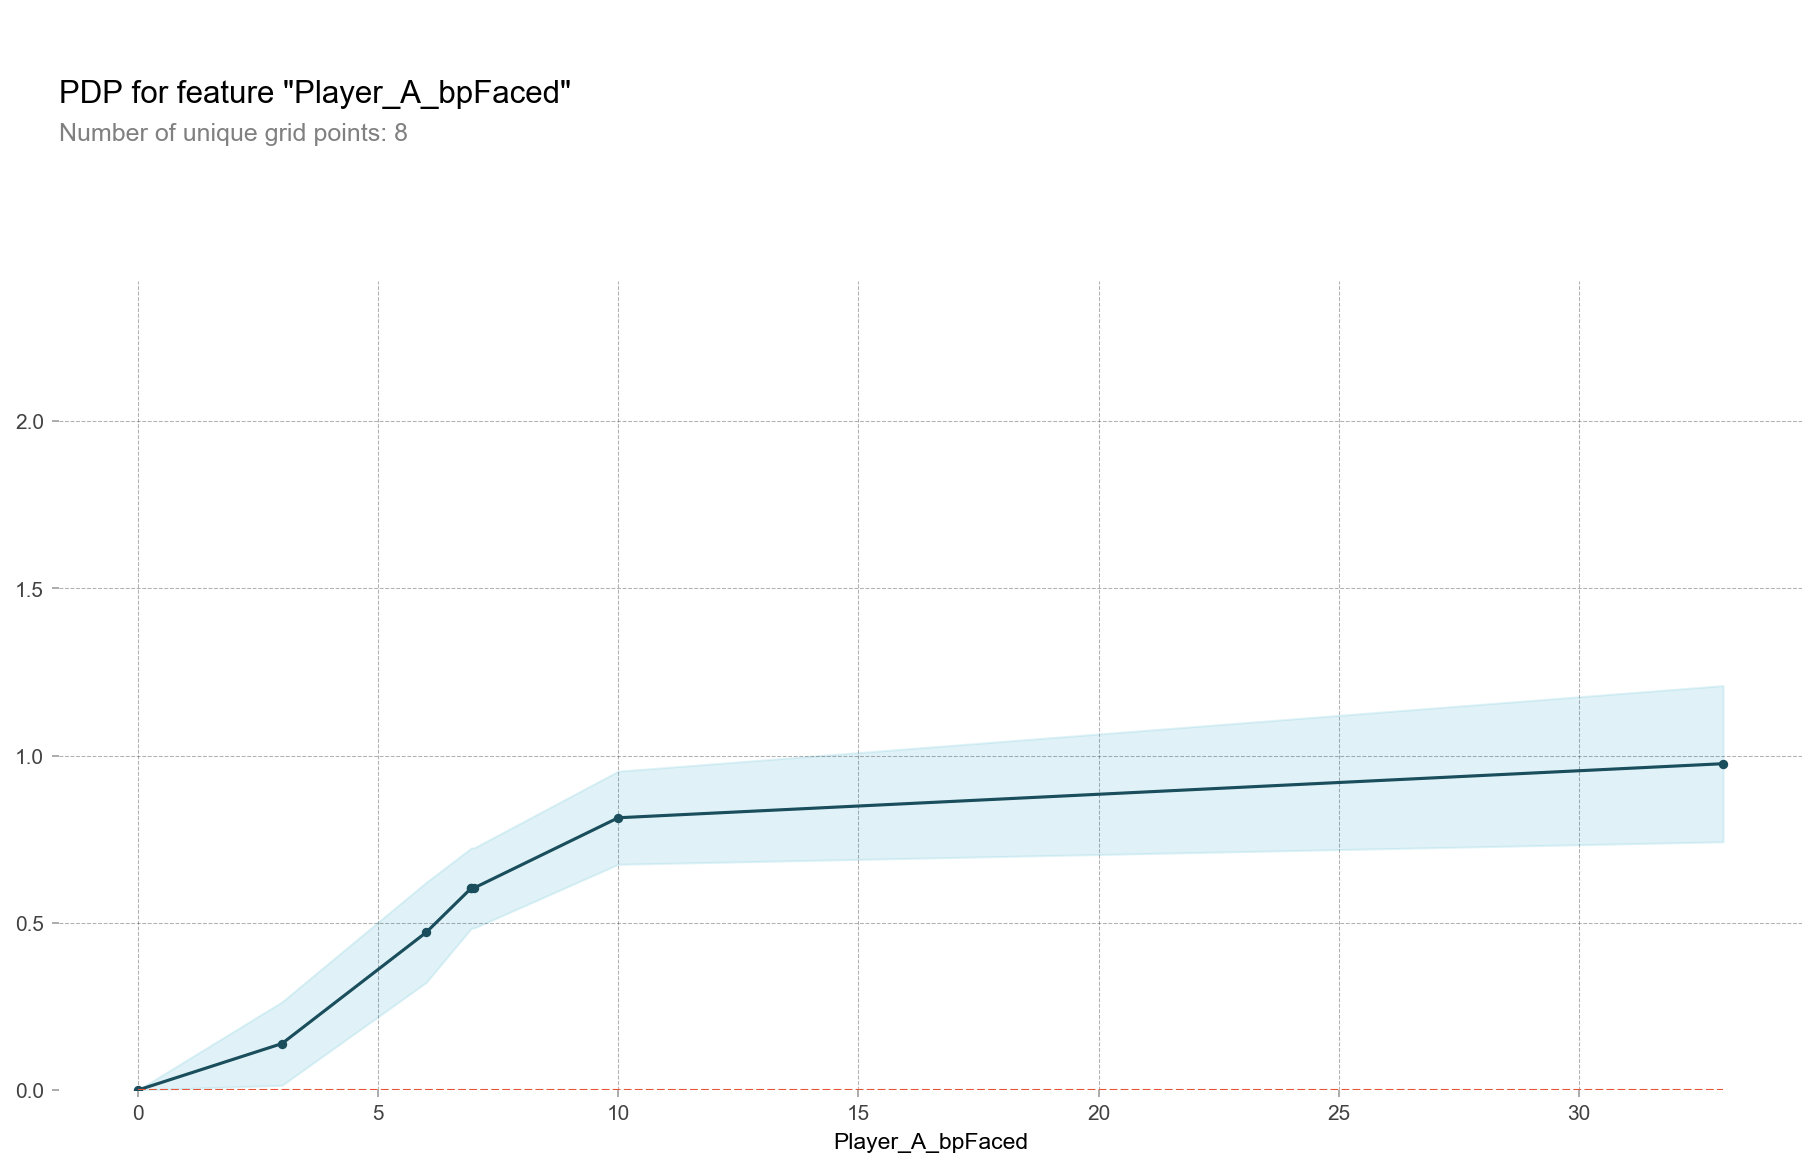

In [44]:
from pdpbox.pdp import pdp_isolate, pdp_plot

X_val_fin['Player_A_bpFaced'].fillna((X_val_fin['Player_A_bpFaced'].mean()), inplace=True)

feature='Player_A_bpFaced'

isolated = pdp_isolate(
    model=gb,
    dataset=X_val_fin,
    model_features=X_val_fin.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

# PDP for variable Player_A_bpFaced is really helpful in explaining how the feature
# interacts with my predictive model.

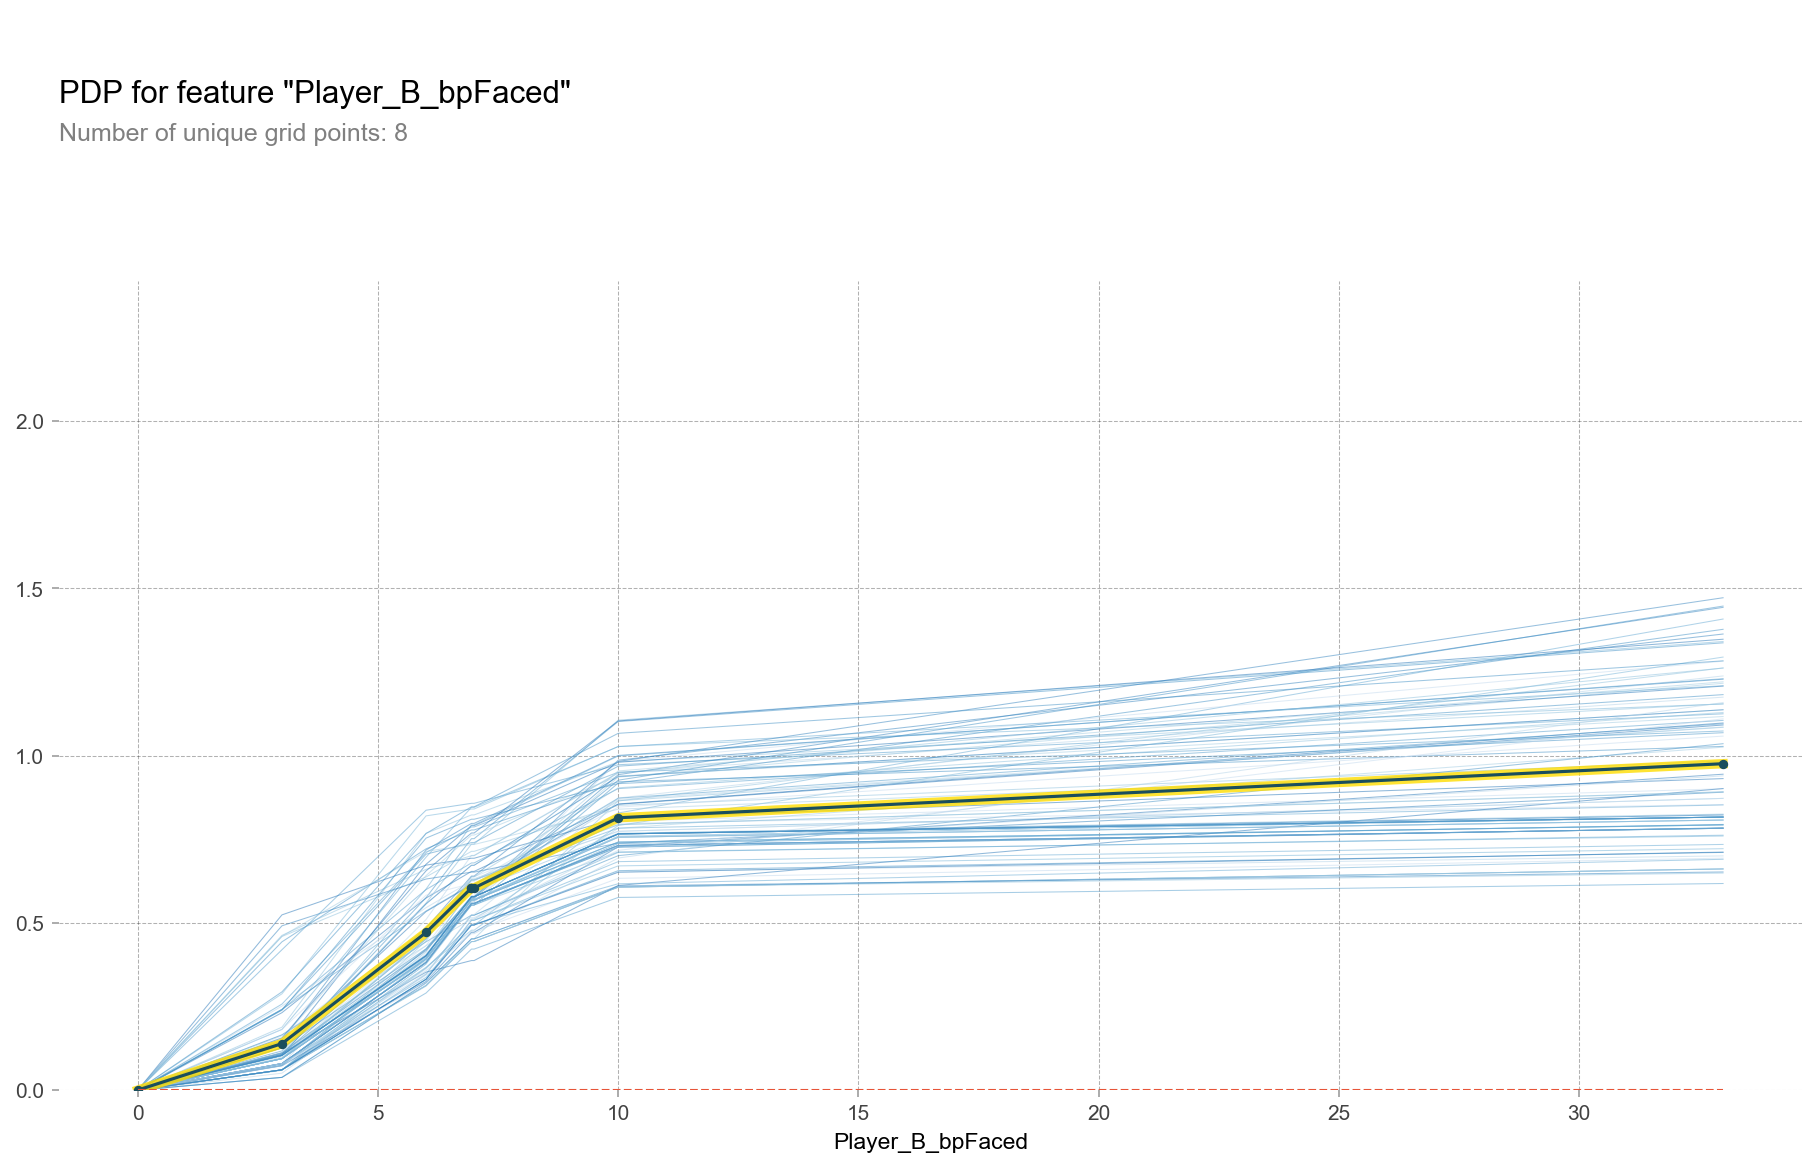

In [45]:
pdp_plot(isolated, feature_name='Player_B_bpFaced', plot_lines=True, frac_to_plot=100) # Confusing parameter name
plt.xlim();

# PDP for Player_B_bpFaced, but showing all observations along with the average (which is the bolder line)

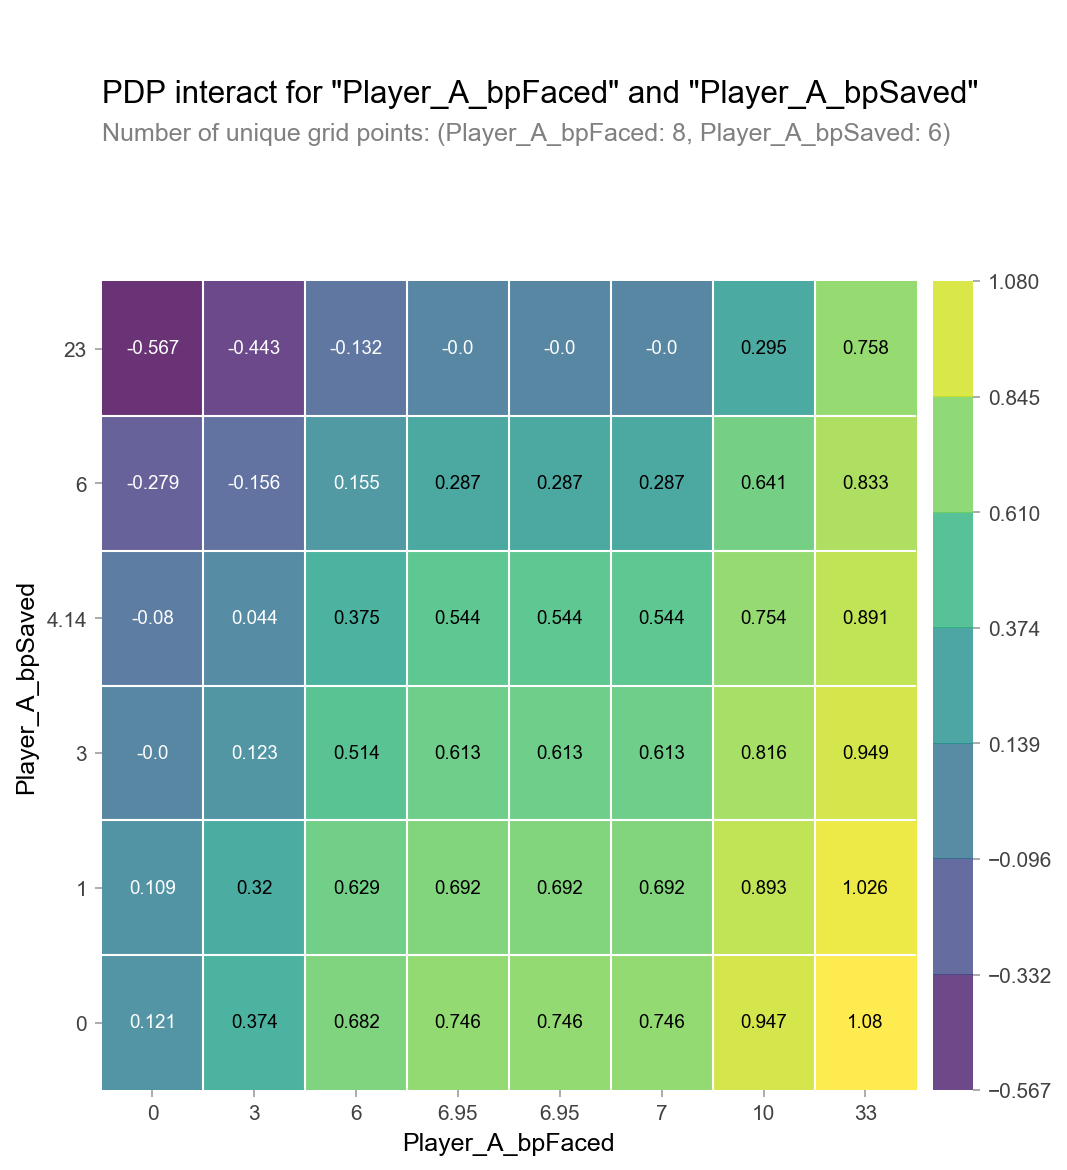

In [46]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

X_val_fin['Player_A_bpFaced'].fillna((X_val_fin['Player_A_bpFaced'].mean()), inplace=True)
X_val_fin['Player_A_bpSaved'].fillna((X_val_fin['Player_A_bpSaved'].mean()), inplace=True)


features= ['Player_A_bpFaced', 'Player_A_bpSaved']

interaction = pdp_interact(
    model=gb,
    dataset=X_val_fin,
    model_features=X_val_fin.columns,
    features=features

)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# Now a PDP for these two features, Player_A_bpFaced and Player_A_bpSaved. This is interesting
# because the two variables predict in the opposite direction of one another.

In [47]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed_fin = processor.fit_transform(X_train_fin)
X_val_processed_fin = processor.transform(X_val_fin)

eval_set = [(X_train_processed_fin, y_train_fin), 
            (X_val_processed_fin, y_val_fin)]

model = XGBClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train_processed_fin, y_train_fin, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=50
         )

# Training a model to find the ROC AUC of my model. 

[0]	validation_0-auc:0.70326	validation_1-auc:0.705842
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.734147	validation_1-auc:0.728198
[2]	validation_0-auc:0.753695	validation_1-auc:0.744439
[3]	validation_0-auc:0.755594	validation_1-auc:0.746621
[4]	validation_0-auc:0.759098	validation_1-auc:0.750226
[5]	validation_0-auc:0.760128	validation_1-auc:0.751702
[6]	validation_0-auc:0.760349	validation_1-auc:0.75184
[7]	validation_0-auc:0.762066	validation_1-auc:0.753521
[8]	validation_0-auc:0.76394	validation_1-auc:0.754886
[9]	validation_0-auc:0.778018	validation_1-auc:0.760214
[10]	validation_0-auc:0.779074	validation_1-auc:0.760881
[11]	validation_0-auc:0.77969	validation_1-auc:0.762924
[12]	validation_0-auc:0.787005	validation_1-auc:0.770803
[13]	validation_0-auc:0.789103	validation_1-auc:0.772327
[14]	validation_0-auc:0.793339	validation_1-auc:0.768869
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
import joblib
import sklearn
import category_encoders as ce
import xgboost
print(f'xgboost=={xgboost.__version__}')
print(f'joblib=={joblib.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'category_encoders=={ce.__version__}')

# Finds the versions of these libraries I need for my dash app.

xgboost==0.90
joblib==0.14.0
scikit-learn==0.21.3
category_encoders==2.1.0


In [ ]:
# Importing my pipeline to my dash app.

from joblib import dump
dump(pipeline, 'pipeline.joblib', compress=True)